In [1]:
# ROOT Library
from ROOT import TMVA, TFile, TTree, TCut, TString
# DNN Library Pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Optimizer SWATS
import swats
#numpy, pandas, matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import random
from array import array
# ML library
import pickle
import scikitplot as skplt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
# XGBoost Library
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython import display
import graphviz
# Cuda Library
from numba import cuda
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from math import sqrt
import gc
from scipy.stats import poisson
from importlib import reload

Welcome to JupyROOT 6.19/01


Load signal and background files used to do input feature normalization:

In [2]:
signalFile = TFile.Open("../sample-train-pDNN-1119/2tag_sr1_sig.root")
backgroundFile = TFile.Open("../sample-train-pDNN-1119/2tag_sr1_bkg.root")
signalTree = signalFile.Get("ntup")
backgroundTree = backgroundFile.Get("ntup")
signalNum = signalTree.GetEntries()
backgroundNum = backgroundTree.GetEntries()
print("signal events number before cut is: ", signalNum)
print("background events number before cut is: ", backgroundNum)

signal events number before cut is:  847545
background events number before cut is:  22274444


Set which region's DNN model you want to use:
region 1: high mass same flavor
region 2: high mass different flavor
region 3: low mass same flavor 
region 4: low mass different flavor

In [3]:
region=4

In [4]:
if((region == 2) | (region ==4)):
    sig_variable_names=["weight","m_hh_truth","is_em","is_me","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"]
    variable_names=["weight","is_em","is_me","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"]
if((region == 1) | (region ==3)):
    sig_variable_names=["weight","m_hh_truth","is_ee","is_mm","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"]
    variable_names=["weight","is_ee","is_mm","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"]

In [5]:
signalArray = signalTree.AsMatrix(sig_variable_names)
backgroundArray = backgroundTree.AsMatrix(sig_variable_names)
signal_df = pd.DataFrame(data=signalArray, columns=sig_variable_names)
background_df = pd.DataFrame(data=backgroundArray, columns=sig_variable_names)

In [6]:
signal_df = signal_df[(signal_df["m_hh_truth"]>0)]

In [ ]:
signal_df = signal_df[((signal_df["m_hh_truth"]<255)|(signal_df["m_hh_truth"]>265))]

In [ ]:
signal_df = signal_df[((signal_df["m_hh_truth"]>395)&(signal_df["m_hh_truth"]<405))]

In [ ]:
#signal_df = signal_df[(signal_df["m_hh_truth"]>0)]
signal_df = signal_df.drop(columns=["m_hh_truth"])
background_df = background_df.drop(columns=["m_hh_truth"])

Prepare matrix use to do normalization:

In [7]:
def sample_value(leng, target_df, weight_df, variable_name, weight_name):
    target_np = target_df[variable_name].values
    weight_np = weight_df[weight_name].values
    sum_weight = sum(weight_np)
    weight_np = weight_np/sum_weight
    result_np = []
    #for num in source_np:
        #source_np[i] = np.random.choice(target_np, p = weight_np, replace=True)
        #i=i+1
        #print(i)
    result_np = np.random.choice(target_np, p = weight_np, replace=True,size=leng)
    return(result_np)

In [8]:
if(region == 1):
    signal_df_region = signal_df[(signal_df["ll_m"] > 75000.0) & (signal_df["ll_m"] < 110000.0) & (
        (signal_df["is_ee"] == 1) | (signal_df["is_mm"] == 1))]
    background_df_region = background_df[(background_df["ll_m"] > 75000.0) & (background_df["ll_m"] < 110000.0) & (
        (background_df["is_ee"] == 1) | (background_df["is_mm"] == 1))]
if(region == 2):
    signal_df_region = signal_df[(signal_df["ll_m"] > 75000.0) & (signal_df["ll_m"] < 110000.0) & (
        (signal_df["is_em"] == 1) | (signal_df["is_me"] == 1))]
    background_df_region = background_df[(background_df["ll_m"] > 75000.0) & (background_df["ll_m"] < 110000.0) & (
        (background_df["is_em"] == 1) | (background_df["is_me"] == 1))]

if(region == 3):
    signal_df_region = signal_df[(signal_df["ll_m"] < 75000.0) & (
        (signal_df["is_ee"] == 1) | (signal_df["is_mm"] == 1))]
    background_df_region = background_df[(background_df["ll_m"] < 75000.0) & (
        (background_df["is_ee"] == 1) | (background_df["is_mm"] == 1))]
if(region == 4):
    signal_df_region = signal_df[(signal_df["ll_m"] < 75000.0) & (
        (signal_df["is_em"] == 1) | (signal_df["is_me"] == 1))]
    background_df_region = background_df[(background_df["ll_m"] < 75000.0) & (
        (background_df["is_em"] == 1) | (background_df["is_me"] == 1))]

signal_df_cut = signal_df_region#[(signal_df_region["bb_m"] > 80000.0) & (
    #signal_df_region["bb_m"] < 150000.0) & (signal_df_region["bb_deltar"] < 2.8)]
background_df_cut = background_df_region#[(background_df_region["bb_m"] > 80000.0) & (
   # background_df_region["bb_m"] < 150000.0) & (background_df_region["bb_deltar"] < 2.8)]

SigYield1 = signal_df_cut["weight"].sum()
BkgYield1 = background_df_cut["weight"].sum()
SBratio = SigYield1/BkgYield1
print("signal yield in region", region, " after precut is: ", SigYield1)
print("background yield in region", region, " after precut is: ", BkgYield1)
print("S/B ratio is: ", SBratio)

signal yield in region 4  after precut is:  93376.2260275839
background yield in region 4  after precut is:  697642.5163715091
S/B ratio is:  0.13384537759143558


In [9]:
signal_df_cor = signal_df_cut.drop(columns=["weight","is_em","is_me"])

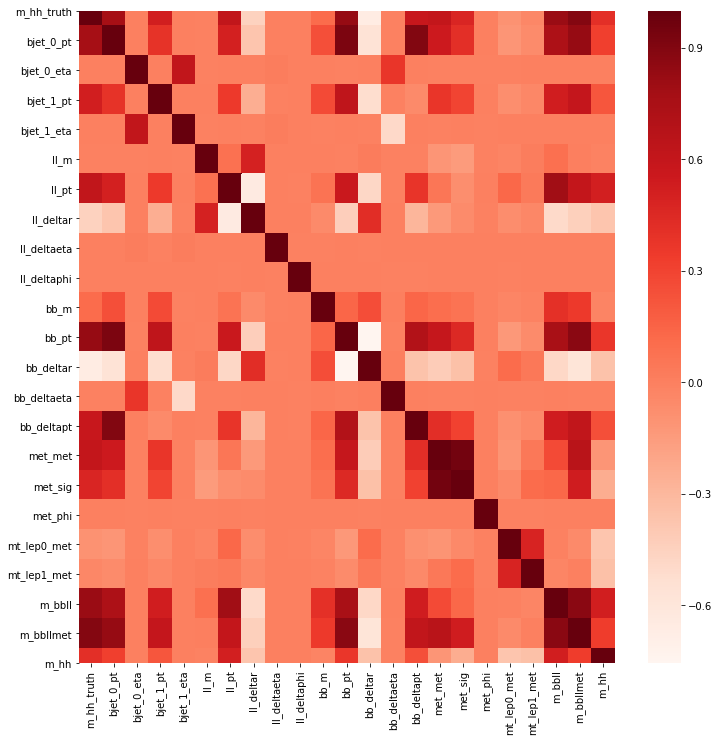

In [10]:
plt.figure(figsize=(12, 12))
cor = signal_df_cor.corr()
cor.style.set_precision(2)
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'

figure_fig.savefig('../figures/1123/corr_sig.pdf', format='pdf', dpi=500)

In [11]:
var1=["m_hh_truth","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"]

In [13]:
import cuda_guass_normal

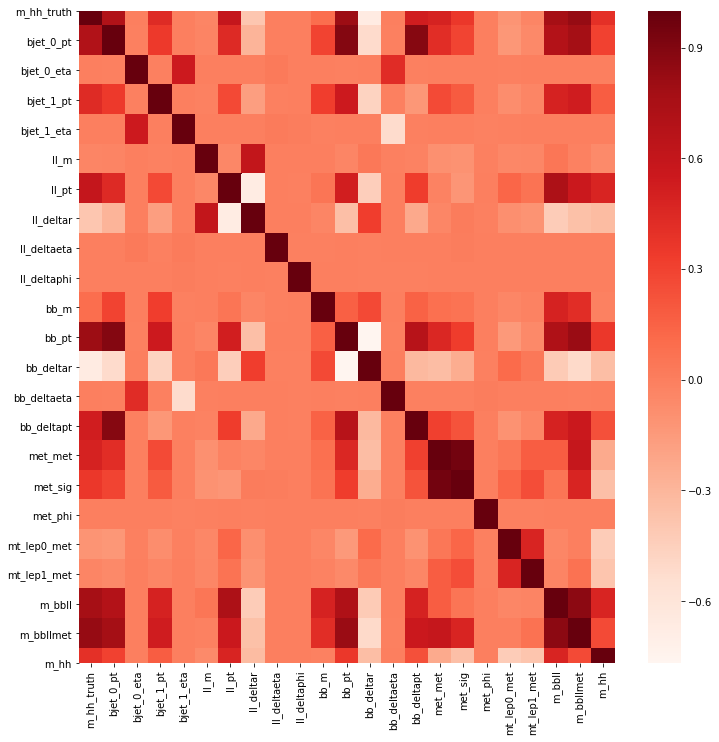

In [14]:
cuda_cor=cuda_guass_normal.cuda_correlation(signal_df_cor.values, signal_df_cut["weight"].values, var1)
plt.figure(figsize=(12, 12))
sns.heatmap(cuda_cor, annot=False, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'

In [15]:
result_np = sample_value(len(background_df_cut["m_hh_truth"].values), signal_df_cut, signal_df_cut,
                         "m_hh_truth","weight")

/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'm_hh_truth [GeV]')

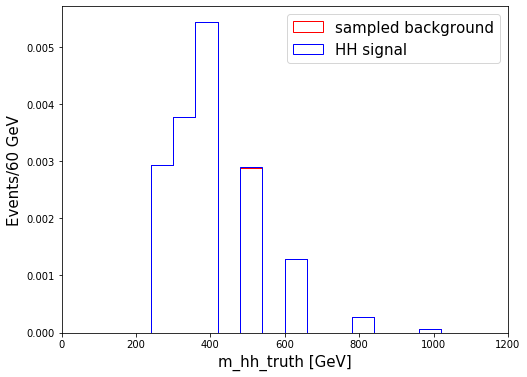

In [16]:
plt.figure(figsize=(8,6))
plt.hist(result_np,bins=20,range=[0,1200],weights=background_df_cut["weight"].values,fill=False, color='red',normed=1,histtype='step',label="sampled background")
plt.hist(signal_df_cut["m_hh_truth"].values,bins=20,range=[0,1200],weights=signal_df_cut["weight"].values,fill=False, color='blue',normed=1,histtype='step',label="HH signal")
plt.legend(loc = 'upper right',prop={'size': 15})
plt.xlim(0,1200)
plt.ylabel('Events/60 GeV',fontsize=15)
plt.xlabel('m_hh_truth [GeV]',fontsize=15)

Text(0.5, 0, 'Pytorch Score')

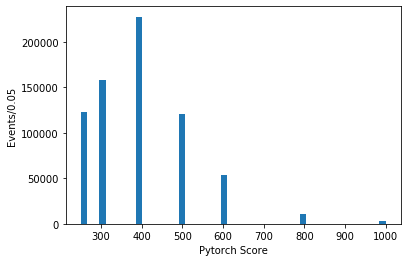

In [17]:
background_df_cut_np = background_df_cut.values

background_df_cut_np[:,1]=result_np

background_df_cut = pd.DataFrame(data=background_df_cut_np, columns=sig_variable_names)

plt.hist(background_df_cut["m_hh_truth"].values,bins=50,weights=background_df_cut["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

In [18]:
background_df_cor = background_df_cut.drop(columns=["weight","is_em","is_me"])

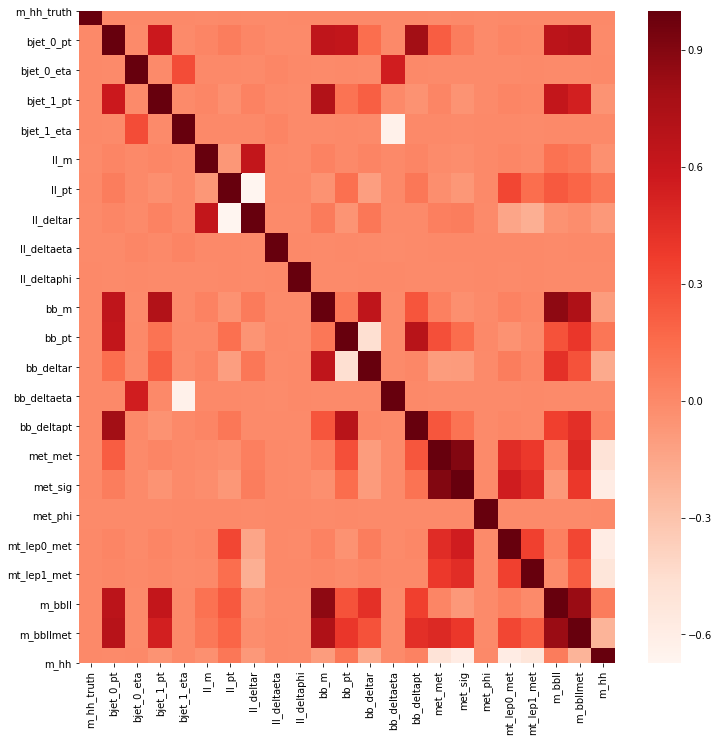

In [19]:
plt.figure(figsize=(12, 12))
cor = background_df_cor.corr()
cor.style.set_precision(2)
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'

figure_fig.savefig('../figures/1123/corr_bkg.pdf', format='pdf', dpi=500)

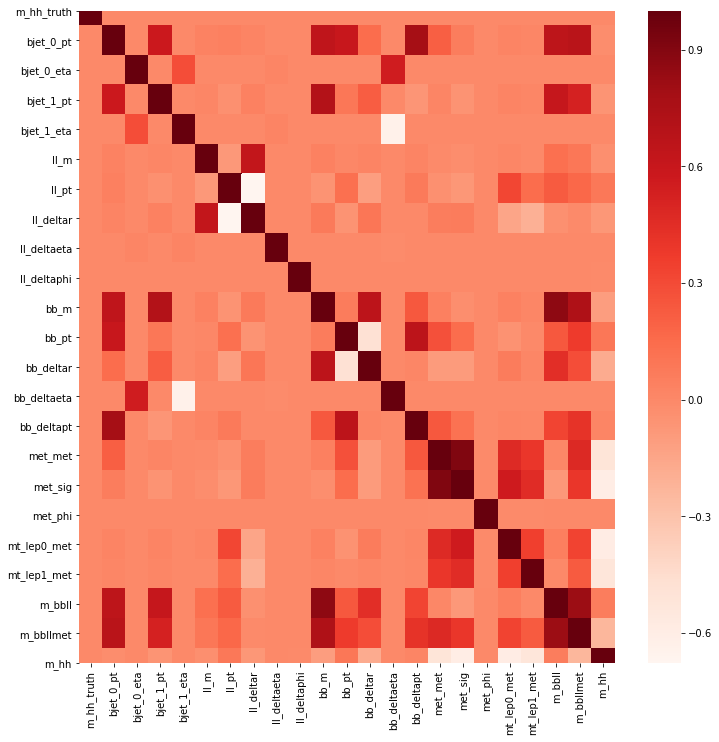

In [20]:
cuda_cor=cuda_guass_normal.cuda_correlation(background_df_cor.values, background_df_cut["weight"].values, var1)
plt.figure(figsize=(12, 12))
sns.heatmap(cuda_cor, annot=False, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(background_df_cut["m_hh"]/1000,bins=20,range=[0,2000],weights=background_df_cut["weight"].values,fill=False, color='red',normed=1,histtype='step',label="sampled background")
plt.hist(signal_df_cut["m_hh"].values/1000,bins=20,range=[0,2000],weights=signal_df_cut["weight"].values,fill=False, color='blue',normed=1,histtype='step',label="HH signal")
plt.legend(loc = 'upper right',prop={'size': 15})
plt.xlim(0,2000)
plt.ylabel('Events/100 GeV',fontsize=15)
plt.xlabel('m_hh [GeV]',fontsize=15)

In [ ]:
dataNormal_pre = signal_df_cut.append(background_df_cut)
dataNormal_weight_df = dataNormal_pre["weight"]
if((region == 4) | (region == 2)):
    dataNormal_df = dataNormal_pre.drop(columns=["weight", "is_em", "is_me"])
if((region == 3) | (region == 1)):
    dataNormal_df = dataNormal_pre.drop(columns=["weight", "is_ee", "is_mm"])
dataNormal_df.describe()
dataNormal = dataNormal_df.values
dataNormal_weight = dataNormal_weight_df.values

Create same NN structure as trainning:

In [ ]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x *( torch.tanh(F.softplus(x)))

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.utils.weight_norm(nn.Linear(22, 100),name='weight')
        self.relu1 = Mish()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu2 = Mish()
        self.fc3 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu3 = Mish()
        self.fc4 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu4 = Mish()
        self.out = nn.utils.weight_norm(nn.Linear(100, 1),name='weight')
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.fc2(h2)
        h3 = self.relu3(a3)
        a4 = self.fc2(h3)
        h4 = self.relu4(a4)
        a5 = self.out(h4)
        y = self.out_act(a5)
        return y

Define function use to apply DNN:

In [ ]:
def eval_pytorch(model, device, input_loader):
    output_numpy = [1]
    model.eval()
    with torch.no_grad():
        for batch_idx, (data1) in enumerate(input_loader):
            score = model(data1)
            del data1
            score_np = score.data.cpu().numpy()
            output_numpy = np.vstack((output_numpy, score_np))
            torch.cuda.empty_cache()
    return(output_numpy)

Import cuda library:

In [ ]:
import cuda_guass_normal

In [ ]:
def apply_dnn(filename, treename, branchname):

    file = TFile.Open(filename)
    dataTree = file.Get(treename)
    dataArray = dataTree.AsMatrix(["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"])
    reload(cuda_guass_normal)
    dataSample = cuda_guass_normal.guass_normal(
        dataArray, dataNormal, dataNormal_weight)
    #Send DNN to GPU
    device = torch.device("cuda:0")
    model = Net().to(device)
    #Load saved DNN model
    model.load_state_dict(torch.load('../pDNN_model/region4-pytorch-1122-400.pt'))
    #Prepare dataloader feed to DNN
    dataTensor = torch.tensor(dataSample, dtype=torch.float).to(device)
    dataLoader = DataLoader(dataTensor, batch_size=10000, shuffle=False)
    dataScore = eval_pytorch(model, device, dataLoader)
    file.Close()
    writefile = TFile.Open(filename, "update")
    writeTree = writefile.Get(treename)
    #Create new DNN branch
    DNN = array("f", [0])
    #Branch type: float
    writename = branchname+"/F"
    #Load new branch
    DNNBranch = writeTree.Branch(branchname, DNN, writename)
    datascore = dataScore[1:, 0]
    writescore = datascore
    i = 0
    #Write DNN score to minitree
    for Score in writescore:
        i = i+1
        if(i % 5000 == 0):
            print("looping: ", i)
        DNN[0] = Score
        DNNBranch.Fill()
    writeTree.Write()
    writefile.Write()
    writefile.Close()

    return(dataScore)

In [ ]:
def apply_pdnn(filename, treename, branchname, reFill, parameter_pos, parameter_value):

    file = TFile.Open(filename)
    dataTree = file.Get(treename)
    dataArray = dataTree.AsMatrix(["m_hh_truth","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"])
    if(reFill==1):
        print("Refill variable ")
        dataArray[:,parameter_pos]=parameter_value
    reload(cuda_guass_normal)
    dataSample = cuda_guass_normal.guass_normal(
        dataArray, dataNormal, dataNormal_weight)
    #Send DNN to GPU
    device = torch.device("cuda:0")
    model = Net().to(device)
    #Load saved DNN model
    model.load_state_dict(torch.load('../pDNN_model/region4-pytorch-1122.pt'))
    #Prepare dataloader feed to DNN
    dataTensor = torch.tensor(dataSample, dtype=torch.float).to(device)
    dataLoader = DataLoader(dataTensor, batch_size=10000, shuffle=False)
    dataScore = eval_pytorch(model, device, dataLoader)
    file.Close()
    writefile = TFile.Open(filename, "update")
    writeTree = writefile.Get(treename)
    #Create new DNN branch
    DNN = array("f", [0])
    #Branch type: float
    writename = branchname+"/F"
    #Load new branch
    DNNBranch = writeTree.Branch(branchname, DNN, writename)
    datascore = dataScore[1:, 0]
    writescore = datascore
    i = 0
    #Write DNN score to minitree
    for Score in writescore:
        i = i+1
        if(i % 5000 == 0):
            print("looping: ", i)
        DNN[0] = Score
        DNNBranch.Fill()
    writeTree.Write()
    writefile.Write()
    writefile.Close()

    return(dataScore)

In [ ]:
sample_list=["2tag_sr1_sig.root"]

In [ ]:
for sample_name in sample_list:
    print("Applying ",sample_name)
    sample="/lustre/samples/di-higgs/pDNN-applied-1122/"+sample_name
    sigScore=apply_dnn(sample,"ntup","pytorch_Region4_DNN_400")

In [ ]:
for sample_name in sample_list:
    print("Applying ",sample_name)
    sample="/lustre/samples/di-higgs/pDNN-applied-1122/"+sample_name
    sigScore=apply_pdnn(sample,"ntup","pytorch_Region4_pDNN_300",0,0,800)